<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: BinhLai_Dataset

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. Set up the training environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Train DRL Agent](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTest with DJIA](#6.1)
    * [7.2. BackTest with Buy&Hold Strategy](#6.2)
* [8.Save & load model](#7)
    * [8.1. Save model](#7.1)
    * [8.2. Load model](#7.2)

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

ERROR! Session/line number was not unique in database. History logging moved to new session 2


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import math
from stable_baselines3.common.logger import configure

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

2024-03-05 20:26:28.451555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2019-01-01'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2021-01-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (88061, 8)


In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743888,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,42.406395,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.144914,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,30.950008,7117200,CAT,4


In [8]:
df.tail()

,date,open,high,low,close,volume,tic,day
88056,2020-12-31,345.040009,351.089996,344.049988,336.380646,1969000,UNH,3
88057,2020-12-31,218.399994,219.820007,216.199997,213.664169,5922200,V,3
88058,2020-12-31,58.060001,58.799999,58.020000,48.816624,12906300,VZ,3
88059,2020-12-31,39.330002,40.000000,39.029999,33.866371,7696000,WBA,3
88060,2020-12-31,48.066666,48.090000,47.616669,45.866276,17814000,WMT,3


In [9]:
df.shape

(88061, 8)

In [10]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743888,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,42.406395,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.144914,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,30.950008,7117200,CAT,4


In [11]:
len(df.tic.unique())

30

In [12]:
df.tic.value_counts()

tic
AAPL    3021
AMGN    3021
WMT     3021
WBA     3021
VZ      3021
V       3021
UNH     3021
TRV     3021
PG      3021
NKE     3021
MSFT    3021
MRK     3021
MMM     3021
MCD     3021
KO      3021
JPM     3021
JNJ     3021
INTC    3021
IBM     3021
HON     3021
HD      3021
GS      3021
DIS     3021
CVX     3021
CSCO    3021
CRM     3021
CAT     3021
BA      3021
AXP     3021
DOW      452
Name: count, dtype: int64

<a id='3'></a>
# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Compustat via WRDS(Wharton Research Data Service)
- Preprocess the dataset and calculate financial ratios
- Add those ratios to the price data preprocessed in Part 3
- Calculate price-related ratios such as P/E and P/B

<a id='3.1'></a>
## 4.1 Import the financial data

In [13]:
# Import fundamental data from my GitHub repository
url = 'https://raw.githubusercontent.com/mariko-sawada/FinRL_with_fundamental_data/main/dow_30_fundamental_wrds.csv'

fund = pd.read_csv(url)

In [14]:
# Check the imported dataset
fund.head()

,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,dvpsxq,mkvaltq,prccq,prchq,prclq,adjex,ggroup,gind,gsector,gsubind
0,1447,19990630,1999,2,12,INDL,C,D,STD,AXP,...,0.225,NaN,130.1250,142.6250,114.5000,3.0,4020,402020,40,40202010
1,1447,19990930,1999,3,12,INDL,C,D,STD,AXP,...,0.000,NaN,135.0000,150.6250,121.8750,3.0,4020,402020,40,40202010
2,1447,19991231,1999,4,12,INDL,C,D,STD,AXP,...,0.225,NaN,166.2500,168.8750,130.2500,3.0,4020,402020,40,40202010
3,1447,20000331,2000,1,12,INDL,C,D,STD,AXP,...,0.225,NaN,148.9375,169.5000,119.5000,3.0,4020,402020,40,40202010
4,1447,20000630,2000,2,12,INDL,C,D,STD,AXP,...,0.080,NaN,52.1250,57.1875,43.9375,1.0,4020,402020,40,40202010


In [15]:
fund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Columns: 647 entries, gvkey to gsubind
dtypes: float64(617), int64(12), object(18)
memory usage: 12.1+ MB


<a id='3.2'></a>
## 4.2 Specify items needed to calculate financial ratios
- To learn more about the data description of the dataset, please check WRDS's website(https://wrds-www.wharton.upenn.edu/). Login will be required.

In [16]:
# List items that are used to calculate financial ratios

items = [
    'datadate', # Date
    'tic', # Ticker
    'oiadpq', # Quarterly operating income
    'revtq', # Quartely revenue
    'niq', # Quartely net income
    'atq', # Total asset
    'teqq', # Shareholder's equity
    'epspiy', # EPS(Basic) incl. Extraordinary items
    'ceqq', # Common Equity
    'cshoq', # Common Shares Outstanding
    'dvpspq', # Dividends per share
    'actq', # Current assets
    'lctq', # Current liabilities
    'cheq', # Cash & Equivalent
    'rectq', # Recievalbles
    'cogsq', # Cost of  Goods Sold
    'invtq', # Inventories
    'apq',# Account payable
    'dlttq', # Long term debt
    'dlcq', # Debt in current liabilites
    'ltq' # Liabilities   
]

# Omit items that will not be used
fund_data = fund[items]

In [17]:
# Rename column names for the sake of readability
fund_data = fund_data.rename(columns={
    'datadate':'date', # Date
    'oiadpq':'op_inc_q', # Quarterly operating income
    'revtq':'rev_q', # Quartely revenue
    'niq':'net_inc_q', # Quartely net income
    'atq':'tot_assets', # Assets
    'teqq':'sh_equity', # Shareholder's equity
    'epspiy':'eps_incl_ex', # EPS(Basic) incl. Extraordinary items
    'ceqq':'com_eq', # Common Equity
    'cshoq':'sh_outstanding', # Common Shares Outstanding
    'dvpspq':'div_per_sh', # Dividends per share
    'actq':'cur_assets', # Current assets
    'lctq':'cur_liabilities', # Current liabilities
    'cheq':'cash_eq', # Cash & Equivalent
    'rectq':'receivables', # Receivalbles
    'cogsq':'cogs_q', # Cost of  Goods Sold
    'invtq':'inventories', # Inventories
    'apq': 'payables',# Account payable
    'dlttq':'long_debt', # Long term debt
    'dlcq':'short_debt', # Debt in current liabilites
    'ltq':'tot_liabilities' # Liabilities   
})

In [18]:
# Check the data
fund_data.date = pd.to_datetime(fund_data['date'],format='%Y%m%d')
fund_data.sort_values('date')
fund_data.head()

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,1999-06-30,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,...,NaN,NaN,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,1999-09-30,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,...,NaN,NaN,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,1999-12-31,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,...,NaN,NaN,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,2000-03-31,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,...,NaN,NaN,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,2000-06-30,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,...,NaN,NaN,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0


In [19]:
fund_data.bfill(inplace=True)

In [20]:
fund_data

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,1999-06-30,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,...,4298.0,1539.0,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,1999-09-30,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,...,4298.0,1539.0,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,1999-12-31,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,...,4298.0,1539.0,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,2000-03-31,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,...,4298.0,1539.0,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,2000-06-30,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,...,4298.0,1539.0,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020-03-31,V,3937.0,5854.0,3084.0,72820.0,34585.0,2.85,29123.0,2134.0,...,19907.0,15942.0,15227.0,2948.0,1725.0,0.0,2030.0,13893.0,3999.0,38235.0
2452,2020-06-30,V,3004.0,4837.0,2373.0,77884.0,35524.0,3.92,30226.0,2128.0,...,25011.0,16100.0,19673.0,3564.0,1636.0,0.0,2878.0,17880.0,2999.0,42360.0
2453,2020-09-30,V,3150.0,5101.0,2137.0,80919.0,36210.0,4.90,31124.0,2124.0,...,27645.0,14510.0,22923.0,2975.0,1755.0,0.0,1910.0,21071.0,2999.0,44709.0
2454,2020-12-31,V,3848.0,5687.0,3126.0,80426.0,37679.0,1.42,33996.0,2137.0,...,26280.0,12390.0,21064.0,3342.0,1642.0,0.0,2179.0,21055.0,0.0,42747.0


<a id='3.3'></a>
## 4.3 Calculate financial ratios
- For items from Profit/Loss statements, we calculate LTM (Last Twelve Months) and use them to derive profitability related ratios such as Operating Maring and ROE. For items from balance sheets, we use the numbers on the day.
- To check the definitions of the financial ratios calculated here, please refer to CFI's website: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

In [21]:
# Calculate financial ratios
date = pd.to_datetime(fund_data['date'],format='%Y%m%d')

tic = fund_data['tic'].to_frame('tic')

# Profitability ratios
# Operating Margin
OPM = (fund_data['op_inc_q']/fund_data['rev_q']).to_frame('OPM')

# Net Profit Margin        
NPM = (fund_data['net_inc_q']/fund_data['rev_q']).to_frame('NPM')

# Return On Assets
ROA = (fund_data['net_inc_q']/fund_data['tot_assets']).to_frame('ROA')

# Return on Equity
ROE = (fund_data['net_inc_q']/fund_data['sh_equity']).to_frame('ROE')

# For calculating valuation ratios in the next subpart, calculate per-share items in advance
# Earnings Per Share       
EPS = fund_data['eps_incl_ex'].to_frame('EPS')

# Book Per Share
BPS = (fund_data['com_eq']/fund_data['sh_outstanding']).to_frame('BPS')

#Dividend Per Share
DPS = fund_data['div_per_sh'].to_frame('DPS')

# Liquidity ratios
# Current ratio
cur_ratio = (fund_data['cur_assets']/fund_data['cur_liabilities']).to_frame('cur_ratio')

# Quick ratio
quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables'] )/fund_data['cur_liabilities']).to_frame('quick_ratio')

# Cash ratio
cash_ratio = (fund_data['cash_eq']/fund_data['cur_liabilities']).to_frame('cash_ratio')


# Efficiency ratios
# Inventory turnover ratio
inv_turnover = (fund_data['cogs_q']/fund_data['inventories']).to_frame('inv_turnover')

# Receivables turnover ratio       
acc_rec_turnover = (fund_data['rev_q']/fund_data['receivables']).to_frame('acc_rec_turnover')

# Payable turnover ratio
acc_pay_turnover = (fund_data['cogs_q']/fund_data['payables']).to_frame('acc_pay_turnover')
        
## Leverage financial ratios
# Debt ratio
debt_ratio = (fund_data['tot_liabilities']/fund_data['tot_assets']).to_frame('debt_ratio')

# Debt to Equity ratio
debt_to_equity = (fund_data['tot_liabilities']/fund_data['sh_equity']).to_frame('debt_to_equity')

In [22]:
# Create a dataframe that merges all the ratios
ratios = pd.concat([date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,
                    cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,
                   debt_ratio,debt_to_equity], axis=1)

In [23]:
# Check the ratio data
ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,0.161035,0.116104,0.004877,0.066175,2.73,21.741648,0.225,2.792723,34.353476,3.961014,10.419643,0.118955,0.209496,0.926298,12.568121
1,1999-09-30,AXP,0.162249,0.116046,0.004886,0.066502,4.18,21.769437,0.225,2.792723,35.041585,3.315140,16.471831,0.114363,0.198330,0.926525,12.610016
2,1999-12-31,AXP,0.140622,0.100849,0.004080,0.060030,5.54,22.588946,0.225,2.792723,41.860949,6.751787,18.642599,0.111210,0.200785,0.932028,13.711937
3,2000-03-31,AXP,0.152799,0.108952,0.004354,0.063981,1.48,23.055993,0.225,2.792723,39.693307,4.824561,16.193651,0.112200,0.193374,0.931947,13.694431
4,2000-06-30,AXP,0.164207,0.116170,0.004981,0.070416,1.05,7.883721,0.080,2.792723,39.718648,4.445094,20.398467,0.117341,0.180255,0.929258,13.135788


In [24]:
ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.672532,0.526819,0.042351,0.089172,2.85,13.647142,0.30,1.248714,1.140070,0.955150,inf,1.985753,0.849754,0.525062,1.105537
2452,2020-06-30,V,0.621046,0.490593,0.030468,0.066800,3.92,14.203947,0.30,1.553478,1.443292,1.221925,inf,1.357183,0.568450,0.543886,1.192433
2453,2020-09-30,V,0.617526,0.418937,0.026409,0.059017,4.90,14.653484,0.30,1.905238,1.784838,1.579807,inf,1.714622,0.918848,0.552515,1.234714
2454,2020-12-31,V,0.676631,0.549675,0.038868,0.082964,1.42,15.908283,0.32,2.121065,1.969814,1.700081,inf,1.701676,0.753557,0.531507,1.134505
2455,2021-03-31,V,0.652994,0.528190,0.037733,0.080274,2.80,16.088525,0.32,2.116356,1.954292,1.700574,inf,1.776434,0.840546,0.529946,1.127414


<a id='3.4'></a>
## 4.4 Deal with NAs and infinite values
After our initial inspection, we’ll want to dig deeper to investigate the following:
- The data type of each variable.
- How discrete/categorical data is coded (and whether we need to make any changes).
- How the data are scaled.
- Whether there is missing data and how it is coded.
- Whether there are outliers.
- The distributions of continuous features.
- The relationships between pairs of features.

### Data types
It is important to check the data type for each feature. 
The ratios should be read in as float64 — and categorical variables should be stored as object 

In [25]:
ratios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2456 non-null   datetime64[ns]
 1   tic               2456 non-null   object        
 2   OPM               2456 non-null   float64       
 3   NPM               2456 non-null   float64       
 4   ROA               2456 non-null   float64       
 5   ROE               2456 non-null   float64       
 6   EPS               2456 non-null   float64       
 7   BPS               2456 non-null   float64       
 8   DPS               2456 non-null   float64       
 9   cur_ratio         2456 non-null   float64       
 10  quick_ratio       2456 non-null   float64       
 11  cash_ratio        2456 non-null   float64       
 12  inv_turnover      2456 non-null   float64       
 13  acc_rec_turnover  2456 non-null   float64       
 14  acc_pay_turnover  2456 n

In [26]:
ratios.isna().sum()

date                0
tic                 0
OPM                 0
NPM                 0
ROA                 0
ROE                 0
EPS                 0
BPS                 0
DPS                 0
cur_ratio           0
quick_ratio         0
cash_ratio          0
inv_turnover        0
acc_rec_turnover    0
acc_pay_turnover    0
debt_ratio          0
debt_to_equity      0
dtype: int64

We see that there is no missing values in all ratios

In [27]:
ratios.dtypes

date                datetime64[ns]
tic                         object
OPM                        float64
NPM                        float64
ROA                        float64
ROE                        float64
EPS                        float64
BPS                        float64
DPS                        float64
cur_ratio                  float64
quick_ratio                float64
cash_ratio                 float64
inv_turnover               float64
acc_rec_turnover           float64
acc_pay_turnover           float64
debt_ratio                 float64
debt_to_equity             float64
dtype: object

Since we have both continuous (float64) and categorical (object) variables in our data, it might be informative to look at the number of unique values in each column using the nunique() function.

In [28]:
ratios.nunique()

date                 263
tic                   29
OPM                 2452
NPM                 2451
ROA                 2450
ROE                 2442
EPS                  789
BPS                 2442
DPS                  203
cur_ratio           2092
quick_ratio         2443
cash_ratio          2442
inv_turnover        2174
acc_rec_turnover    2452
acc_pay_turnover    2450
debt_ratio          2443
debt_to_equity      2442
dtype: int64

In [29]:
# Replace NAs infinite values with zero
final_ratios = ratios.copy()
final_ratios = final_ratios.fillna(0)
final_ratios = final_ratios.replace(np.inf,0)

In [30]:
final_ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,0.161035,0.116104,0.004877,0.066175,2.73,21.741648,0.225,2.792723,34.353476,3.961014,10.419643,0.118955,0.209496,0.926298,12.568121
1,1999-09-30,AXP,0.162249,0.116046,0.004886,0.066502,4.18,21.769437,0.225,2.792723,35.041585,3.315140,16.471831,0.114363,0.198330,0.926525,12.610016
2,1999-12-31,AXP,0.140622,0.100849,0.004080,0.060030,5.54,22.588946,0.225,2.792723,41.860949,6.751787,18.642599,0.111210,0.200785,0.932028,13.711937
3,2000-03-31,AXP,0.152799,0.108952,0.004354,0.063981,1.48,23.055993,0.225,2.792723,39.693307,4.824561,16.193651,0.112200,0.193374,0.931947,13.694431
4,2000-06-30,AXP,0.164207,0.116170,0.004981,0.070416,1.05,7.883721,0.080,2.792723,39.718648,4.445094,20.398467,0.117341,0.180255,0.929258,13.135788


In [31]:
final_ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.672532,0.526819,0.042351,0.089172,2.85,13.647142,0.30,1.248714,1.140070,0.955150,0.0,1.985753,0.849754,0.525062,1.105537
2452,2020-06-30,V,0.621046,0.490593,0.030468,0.066800,3.92,14.203947,0.30,1.553478,1.443292,1.221925,0.0,1.357183,0.568450,0.543886,1.192433
2453,2020-09-30,V,0.617526,0.418937,0.026409,0.059017,4.90,14.653484,0.30,1.905238,1.784838,1.579807,0.0,1.714622,0.918848,0.552515,1.234714
2454,2020-12-31,V,0.676631,0.549675,0.038868,0.082964,1.42,15.908283,0.32,2.121065,1.969814,1.700081,0.0,1.701676,0.753557,0.531507,1.134505
2455,2021-03-31,V,0.652994,0.528190,0.037733,0.080274,2.80,16.088525,0.32,2.116356,1.954292,1.700574,0.0,1.776434,0.840546,0.529946,1.127414


<a id='3.5'></a>
## 4.5 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [32]:
df['date'] = pd.to_datetime(df.date)
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df['date'].min(),df['date'].max()))
combination = list(itertools.product(list_date,list_ticker))

# Merge stock price data and ratios into one dataframe
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
processed_full = processed_full.merge(final_ratios,how='left',on=['date','tic'])
processed_full = processed_full.sort_values(['tic','date'])

# Backfill the ratio data to make them daily
processed_full = processed_full.bfill(axis='rows')

<a id='3.6'></a>
## 4.6 Calculate market valuation ratios using daily stock price data 

In [33]:
# Calculate P/E, P/B and dividend yield using daily closing price
processed_full['PE'] = processed_full['close']/processed_full['EPS']
processed_full['PB'] = processed_full['close']/processed_full['BPS']
processed_full['Div_yield'] = processed_full['DPS']/processed_full['close']

# Drop per share items used for the above calculation
processed_full = processed_full.drop(columns=['day','EPS','BPS','DPS'])
# Replace NAs infinite values with zero
processed_full = processed_full.copy()
processed_full = processed_full.fillna(0)
processed_full = processed_full.replace(np.inf,0)

In [34]:
processed_full = processed_full[processed_full.date.isin(final_ratios.date)]

In [35]:
# Check the final data
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-31,AAPL,3.182143,3.285714,3.175000,2.766868,558247200.0,0.255724,0.178336,0.037468,...,2.039779,1.818995,16.910256,2.992095,1.326962,0.437727,0.778495,0.636062,0.101510,0.000000
1,2009-01-31,AMGN,54.430000,55.709999,54.299999,39.796867,7060400.0,0.095047,0.067428,0.003606,...,57.359324,13.513320,0.000000,0.096045,0.176988,0.869784,6.679531,128.376992,3.685596,0.004523
2,2009-01-31,AXP,16.350000,17.120001,16.070000,13.418344,14544600.0,0.095047,0.067428,0.003606,...,57.359324,13.513320,0.000000,0.096045,0.176988,0.869784,6.679531,43.284979,1.242676,0.013414
3,2009-01-31,BA,41.730000,41.730000,40.110001,30.603237,8107400.0,0.063204,0.036965,0.011023,...,0.368463,0.148507,0.850789,2.503717,0.758503,1.009198,-109.722986,35.176135,-32.235194,0.013724
4,2009-01-31,CAT,30.100000,30.799999,29.600000,20.200167,16966700.0,0.161084,-0.012141,-0.001738,...,0.890488,0.163158,0.812437,0.574194,1.944012,0.893715,9.089489,-106.316667,1.949734,0.020792
5,2009-01-31,CRM,6.625000,6.715000,6.487500,6.660000,9271200.0,0.195071,0.165475,0.024512,...,2.498162,2.170759,2.779584,2.040638,4.923200,0.400215,0.667591,10.571428,1.058126,0.000000
6,2009-01-31,CSCO,14.860000,15.460000,14.830000,10.467291,55290500.0,0.195071,0.165475,0.024512,...,2.498162,2.170759,2.779584,2.040638,4.923200,0.400215,0.667591,16.614747,1.663020,0.000000
7,2009-01-31,CVX,69.519997,70.849998,69.120003,38.525242,12445000.0,0.061614,0.055537,0.011523,...,0.952878,0.373760,4.171437,2.294464,1.966557,0.449174,0.815455,41.875263,0.884524,0.016872
8,2009-01-31,DIS,20.080000,20.500000,19.840000,17.337702,16499500.0,0.159144,0.075801,0.009725,...,0.815629,0.330748,3.235830,1.637376,1.226549,0.455848,0.837721,21.946458,0.948227,0.020187
9,2009-01-31,DOW,52.750000,53.500000,49.500000,38.225895,2350800.0,0.537326,0.403438,0.054307,...,1.236512,0.524199,4.769523,1.192136,7.771188,0.657544,1.920085,166.199543,1.781531,0.000000


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

<a id='4.1'></a>
## 5.1 Training & Trade Data Split
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [36]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

3600
720


In [37]:
train_data = train_data.reset_index(drop=True)
train_data

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-31,AAPL,3.182143,3.285714,3.175000,2.766868,558247200.0,0.255724,0.178336,0.037468,...,2.039779,1.818995,16.910256,2.992095,1.326962,0.437727,0.778495,0.636062,0.101510,0.000000
1,2009-01-31,AMGN,54.430000,55.709999,54.299999,39.796867,7060400.0,0.095047,0.067428,0.003606,...,57.359324,13.513320,0.000000,0.096045,0.176988,0.869784,6.679531,128.376992,3.685596,0.004523
2,2009-01-31,AXP,16.350000,17.120001,16.070000,13.418344,14544600.0,0.095047,0.067428,0.003606,...,57.359324,13.513320,0.000000,0.096045,0.176988,0.869784,6.679531,43.284979,1.242676,0.013414
3,2009-01-31,BA,41.730000,41.730000,40.110001,30.603237,8107400.0,0.063204,0.036965,0.011023,...,0.368463,0.148507,0.850789,2.503717,0.758503,1.009198,-109.722986,35.176135,-32.235194,0.013724
4,2009-01-31,CAT,30.100000,30.799999,29.600000,20.200167,16966700.0,0.161084,-0.012141,-0.001738,...,0.890488,0.163158,0.812437,0.574194,1.944012,0.893715,9.089489,-106.316667,1.949734,0.020792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2018-12-31,UNH,248.059998,250.279999,246.940002,231.183151,3123200.0,0.076981,0.052040,0.019971,...,0.612190,0.269203,0.000000,3.200932,1.218166,0.630623,1.767227,18.568928,4.293095,0.003893
3596,2018-12-31,V,131.679993,132.440002,130.229996,127.279060,7976000.0,0.676353,0.540683,0.041546,...,1.426843,1.088655,0.000000,1.215989,0.404335,0.524178,1.101628,97.906970,9.784542,0.001964
3597,2018-12-31,VZ,55.529999,56.230000,55.070000,42.939354,15331800.0,0.211050,0.056562,0.007322,...,0.781730,0.099974,11.445359,1.325689,2.114353,0.793414,3.840596,11.420041,3.338542,0.014031
3598,2018-12-31,WBA,68.540001,68.720001,67.739998,53.873093,4870900.0,0.048685,0.033480,0.016413,...,0.349247,0.039877,2.574443,4.410833,1.828199,0.639194,1.771574,22.169997,1.988272,0.008167


In [38]:
trade_data = trade_data.reset_index(drop=True)
trade_data

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-31,AAPL,41.527500,42.250000,41.139999,39.886833,162958400.0,0.231233,0.199276,0.033804,...,1.134347,0.854114,6.788288,2.207740,1.089052,0.690466,2.230663,5.953259,1.735972,0.018302
1,2019-01-31,AMGN,184.779999,187.600006,183.910004,159.341476,4397900.0,0.095047,0.067428,0.003606,...,57.359324,13.513320,0.000000,0.096045,0.176988,0.869784,6.679531,514.004763,14.756648,0.001130
2,2019-01-31,AXP,102.000000,102.900002,101.699997,95.703987,4302100.0,0.199130,0.137668,0.007860,...,116.940221,24.546459,0.000000,0.079181,0.096330,0.887329,7.875371,52.875131,3.605376,0.004075
3,2019-01-31,BA,387.160004,388.989990,382.079987,374.705719,6878500.0,0.097744,0.093773,0.017877,...,0.262465,0.092436,0.276981,1.611943,1.232287,0.998070,517.142241,98.866944,1688.906591,0.005484
4,2019-01-31,CAT,130.320007,133.339996,129.039993,118.100624,6643300.0,0.203104,0.139685,0.023893,...,0.919490,0.266175,0.675527,0.752585,1.158099,0.803394,4.086316,35.896846,4.373801,0.007282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2020-12-31,UNH,345.040009,351.089996,344.049988,336.380646,1969000.0,0.053722,0.033788,0.011212,...,0.623930,0.273143,0.000000,2.577035,1.120292,0.642459,1.855023,20.725856,4.858929,0.003716
716,2020-12-31,V,218.399994,219.820007,216.199997,213.664169,5922200.0,0.676631,0.549675,0.038868,...,1.969814,1.700081,0.000000,1.701676,0.753557,0.531507,1.134505,150.467725,13.431002,0.001498
717,2020-12-31,VZ,58.060001,58.799999,58.020000,48.816624,12906300.0,0.210596,0.132250,0.014497,...,1.210691,0.589158,8.252784,1.407383,2.223189,0.781118,3.568671,11.352703,2.977647,0.012854
718,2020-12-31,WBA,39.330002,40.000000,39.029999,33.866371,7696000.0,0.062153,0.034870,0.023203,...,0.201841,0.131341,2.325635,27.848143,2.782072,0.587123,1.501283,9.960697,2.036080,0.007013


<a id='4.2'></a>
## 5.2 Set up the training environment

Describe the environment

In [202]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
# from gym.spaces import Box

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        # stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        idle_punishment,
        # turbulence_threshold=None,
        # risk_indicator_col="turbulence",
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        # self.day = day
        self.df = df
        # self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.idle_punishment = idle_punishment
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        # self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        # self.turbulence_threshold = turbulence_threshold
        # self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        self.portfolio_columns = ['tic','price','buy_price','amount','weight']
        self.row = 0
        
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _buy_stock(self, action):
        def _do_buy():
            if self.data.close > 0: # Buy only if the price is > 0 (no missing data in this particular date)
                buy_amount = (self.portfolio.loc[0].price * action)
                buy_num_shares = math.floor(buy_amount/self.data.close)
                if buy_num_shares > 0:
                    if self.portfolio[self.portfolio.tic == self.data.tic].empty:
                        selected_index = len(self.portfolio)
                        selected_row = [self.data.tic,0,self.data.close,0,0]
                    else:
                        selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
                        selected_row = self.portfolio.loc[selected_index]
                        selected_row[2] = (buy_num_shares*self.data.close + selected_row[2]*selected_row[3]) \
                                    /(buy_num_shares + selected_row[3])
                    selected_row[1] = self.data.close
                    selected_row[3] += buy_num_shares
                    self.portfolio.loc[selected_index] = selected_row
    
                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_change = buy_num_shares * self.data.close * (1 + self.buy_cost_pct)
                    capital_row[1] -= capital_change
                    capital_row[2] -= capital_change
                    self.portfolio.loc[0] = capital_row
                    
                    self._compute_weight()
                    self.cost += selected_row[1] * buy_num_shares * self.buy_cost_pct
                    self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        buy_num_shares = _do_buy()
        return buy_num_shares
    
    def _sell_stock(self, action):
        def _do_sell_normal():
            if self.data.close > 0: # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.portfolio[self.portfolio.tic == self.data.tic].empty:            
                    sell_num_shares = 0
                else:
                    sell_num_shares = math.floor(abs(action) * self.portfolio[self.portfolio.tic == self.data.tic].amount) 
                    sell_amount = self.data.close * sell_num_shares * (1 - self.sell_cost_pct) # remember to adjust buy_cost_pct
                    
                    # update stock row in the portfolio
                    selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
                    selected_row = self.portfolio.loc[selected_index]
                    selected_row[1] = self.data.close
                    selected_row[3] -= sell_num_shares
                    self.portfolio.loc[selected_index] = selected_row

                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_row[1] += sell_amount
                    capital_row[2] += sell_amount
                    self.portfolio.loc[0] = capital_row

                    self._compute_weight()
                    self.cost += selected_row[1] * sell_num_shares * self.sell_cost_pct
                    self.trades += 1
            else:
                sell_num_shares = 0

            return sell_num_shares

        sell_num_shares = _do_sell_normal()
        return sell_num_shares

    def _compute_weight(self):
        nav = sum(self.portfolio.price*self.portfolio.amount)
        self.portfolio['weight'] = self.portfolio.apply(lambda x: x.price * x.amount / nav, axis=1)
    
    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = (self.day >= len(self.df.index.unique()) - 1)
        
        # --> IN CASE THE STEP IS THE TERMINATED STEP
        if self.terminal: 
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
                
            # Summary the training performance after an episode
            end_total_asset = sum(self.portfolio.price*self.portfolio.amount)
            tot_reward = end_total_asset - self.initial_amount

            # Summary total_value
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1)
            if df_total_value["daily_return"].std() != 0:
                sharpe = ((252 ** 0.5)* df_total_value["daily_return"].mean()/ df_total_value["daily_return"].std())

            # Summary rewards
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]

            # Print out training results after a certain amount of episodes
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            return self.state, self.reward, self.terminal, {}

        # --> IN A NORMAL STEP
        else: 

            begin_total_asset = sum(self.portfolio.price * self.portfolio.amount)
            
            # update previous_portfolio
            self.previous_port = self.portfolio.copy()
        
            self.data = self.df.loc[self.day]
            if actions[0] > 0:
                self._buy_stock(actions[0])
            else:
                self._sell_stock(actions[0])

            # actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            # actions = actions.astype(int)  # convert into integer because we can't by fraction of shares
            # print(type(actions))
            self.actions_memory.append(actions)

            # Update selected row in the dataset based on state: s -> s+1
            # self.day += 1
            # self.data = self.df.loc[self.day, :]
            self.day += 1
            self.data = self.df.loc[self.day]
            self.state = self._update_state()
    
            end_total_asset = sum(self.portfolio.price * self.portfolio.amount)

            # Update summary arrays
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset - self.initial_amount * self.idle_punishment
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        # Reset asset_memory
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = sum(self.previous_port.price * self.previous_port.amount)
            self.asset_memory = [previous_total_asset]

        # Reset support variables
        # self.day = 0
        # self.data = self.df.loc[self.day, :]
        # self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        
        # Reset portfolio & previous_portfolio
        if self.initial:
            self.portfolio = pd.DataFrame([['cap',self.initial_amount,self.initial_amount,1,1]])
            self.portfolio.columns = self.portfolio_columns
            self.previous_port = self.portfolio.copy()
        else:
            self.portfolio = self.previous_port.copy()

        # Reset data
        self.day = 0
        self.data = self.df.loc[self.day]
        
         # Reset state
        state = self._update_state()
        
        return state

    def _update_state(self):

        print("Current tic: ",self.data.tic)
        # if the stock appear in the portfolio already
        if self.portfolio[self.portfolio.tic == self.data.tic].empty:
            state = ([self.portfolio.loc[0].price] + [0] + [0] + sum([[self.data[tech]] for tech in self.tech_indicator_list], []))
            
        else:
            selected_row = self.portfolio[self.portfolio.tic == self.data.tic]
            state = (
                    [self.portfolio.iloc[0].price]
                    + [(selected_row.buy_price.iloc[0]/selected_row.price.iloc[0]-1)]
                    + [selected_row.weight.iloc[0]]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
    
        return state

    def _get_date(self):
        # return self.data.date
        return self.day

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

<a id='4.3'></a>
## 5.3 Initialize Environment


State's space include current capital amount, the return of the current stock, the weight of this stock in the portfolio, and the indicators decided in ratio_list

In [203]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

action_dimension = 1 # k float in range (-1,1) to decide sell (k<0) or buy (k>0) decisions
state_space = 1 + 2*action_dimension + len(ratio_list)
print(f"Action Dimension: {action_dimension}, State Space: {state_space}")

Action Dimension: 1, State Space: 18


In [204]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "idle_punishment": 0.001
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

Current tic:  AAPL


In [205]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Current tic:  AAPL
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Test environment

In [44]:
from gym.spaces import Box

In [206]:
# Get samples from train_data
sample_data = train_data #.sample(10).reset_index(drop=True)

# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "idle_punishment": 0.001
}

#Establish the training environment using StockTradingEnv() class
test_train_gym = StockTradingEnv(df = sample_data, **env_kwargs)

Current tic:  AAPL


In [99]:
# Define bounds, shape, and data type
lower_bound = -1.0
upper_bound = 1.0
shape = (1,)
dtype = np.float32

# Create the Box object
action_space = Box(low=lower_bound, high=upper_bound, shape=shape, dtype=dtype)

# Sample a value within the action space
action = action_space.sample()

print(f"Action: {action}")

Action: [0.74109656]


In [266]:
# test reset state
test_train_gym.reset()

Current tic:  AAPL


[1000000,
 0,
 0,
 0.25572435050638487,
 0.178335535006605,
 0.03746790942942387,
 0.0666365019949817,
 2.461857319467675,
 2.0397789251690788,
 1.818994982183114,
 16.91025641025641,
 2.992094861660079,
 1.3269617706237424,
 0.43772694682794827,
 0.7784953313314961,
 0.6360615807018062,
 0.10150971416503046,
 0.0]

In [291]:
 # test buying 100 AXP
test_train_gym.step([0.5])
print(test_train_gym.reward)
print(test_train_gym.initial)
print(test_train_gym.previous_port)

Current tic:  UNH
-0.1
True
     tic      price  buy_price  amount    weight
0    cap  17.100509  17.100509       1  0.000017
1   AAPL   2.766868   2.766868  180709  0.500498
2   AMGN  39.796867  39.796867    6275  0.249975
3    AXP  13.418344  13.418344    9297  0.124875
4     BA  30.603237  30.603237    2036  0.062370
5    CAT  20.200167  20.200167    1541  0.031160
6    CRM   6.660000   6.660000    2336  0.015573
7   CSCO  10.467291  10.467291     742  0.007774
8    CVX  38.525242  38.525242     100  0.003856
9    DIS  17.337702  17.337702     112  0.001944
10   DOW  38.225895  38.225895      25  0.000957
11    GS  64.661026  64.661026       7  0.000453
12    HD  14.882809  14.882809      18  0.000268
13   HON  21.441525  21.441525       6  0.000129
14   IBM  51.671104  51.671104       1  0.000052
15  INTC   8.622969   8.622969       6  0.000052
16   JPM  17.350378  17.350378       1  0.000017
17    KO  13.237164  13.237164       1  0.000013
18   MRK  16.011173  16.011173       1  0

In [48]:
print(e_train_gym.state)

[901791.4962274093, 0, 0, 0.09504706063879031, 0.06742786607005091, 0.003606116369457762, 0.027693282636248415, 2.792722547108512, 57.35932423651722, 13.51332033788174, 0.0, 0.0960446953867129, 0.17698811343711976, 0.8697837155376579, 6.679531051964512, 128.3769792126071, 3.68559599058839, 0.004522969498516608]


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Model 1: PPO

In [49]:
# agent_ppo = DRLAgent(env = env_train)
# PPO_PARAMS = {
#     "n_steps": 2048,
#     "ent_coef": 0.01,
#     "learning_rate": 0.00025,
#     "batch_size": 128,
#     "clip_range":0.1
# }
# model_ppo = agent_ppo.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo/")

In [50]:
# trained_ppo = agent_ppo.train_model(model=model_ppo, 
#                              tb_log_name='ppo',
#                              total_timesteps=300000)

### Model 2: DDPG

In [51]:
# agent_ddpg = DRLAgent(env = env_train)
# DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
# model_ddpg = agent_ddpg.get_model("ddpg",model_kwargs = DDPG_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ddpg_tensorboard/")

# # set up logger
# tmp_path = RESULTS_DIR + '/ddpg'
# new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_ddpg)

In [52]:
# the training log just show up when total_timesteps higher than 15.000
# trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
#                              tb_log_name='ddpg',
#                              total_timesteps=1000)

### Model 3: SAC

In [177]:
agent_sac = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent_sac.get_model("sac",model_kwargs = SAC_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_sac/")

# set up logger
tmp_path = RESULTS_DIR + '/sac'
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [178]:
trained_sac = agent_sac.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=300000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 83        |
|    time_elapsed    | 172       |
|    total_timesteps | 14400     |
| train/             |           |
|    actor_loss      | -8.82e+03 |
|    critic_loss     | 4.55e+04  |
|    ent_coef        | 7.41      |
|    ent_coef_loss   | -18.8     |
|    learning_rate   | 0.0003    |
|    n_updates       | 14299     |
|    reward          | -0.1      |
----------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 91       |
|    time_elapsed    | 314      |
|    total_timesteps | 28800    |
| train/             |          |
|    actor_loss      | 6.1e+04  |
|    critic_loss     | 1.72e+07 |
|    ent_coef        | 557      |
|    ent_coef_loss   | -59      |
|    learning_rate   | 0.0003   |
|    n_updates       | 28699    |
|    reward          | -0.1     |

### Model 4: TD3

In [57]:
# agent_td3 = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [58]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=10000)

### Model 5: A2C

In [59]:
# agent_a2c = DRLAgent(env = env_train)

# A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

In [60]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c',
#                                 total_timesteps=10000)

## Trading
Assume that we have $1,000,000 initial capital at the begining. We use the PPO model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [179]:
trade_data = trade_data.reset_index(drop=True)

In [181]:
# trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [182]:
# df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
#     model=trained_ppo, 
#     environment = e_trade_gym)

# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_ddpg, 
#     environment = e_trade_gym)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym) if if_using_a2c else [None, None]

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym) if if_using_td3 else [None, None]

hit end!


In [183]:
# df_account_value_ppo.shape
# df_account_value_ddpg.shape
df_account_value_sac.shape
# df_account_value_td3.shape
# df_account_value_a2c.shape

(720, 2)

In [185]:
df_account_value_sac['date'] = trade_data.date

In [186]:
# df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
df_account_value_sac.tail()
# df_account_value_td3.tail()
# df_account_value_a2c.tail()

,date,account_value
715,2020-12-31,999001.011715
716,2020-12-31,999001.011715
717,2020-12-31,999001.011715
718,2020-12-31,999001.011715
719,2020-12-31,999001.011715


In [191]:
# df_actions_ppo.head()
# df_actions_ddpg.head()
df_actions_sac.head()
# df_actions_td3.head()
# df_actions_a2c.head()

,date,actions
0,0,[0.8977971]
1,1,[0.8977971]
2,2,[0.8977971]
3,3,[0.8982347]
4,4,[0.8977971]


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [196]:
df_account_value = pd.DataFrame(df_account_value_sac.date.unique())
df_account_value.columns = ['date']
df_account_value['account_value'] = df_account_value.apply(lambda x: \
                                    df_account_value_sac[df_account_value_sac.date == x.date].iloc[-1].account_value, axis=1)
df_account_value.head()

,date,account_value
0,2019-01-31,999001.011715
1,2019-02-28,999001.011715
2,2019-03-31,999001.011715
3,2019-04-30,999001.011715
4,2019-05-31,999001.011715


There's a missmatch between the quarterly computation of df_account_value and the daily frequency of the comparison datasets. We need to transform the df_account_value to a daily basis.
To fill up the missing data, th **ffill** function effectively imputes values, providing the continous picture of account value trends until the next recorded change. However, for the entries preceding the first recorded change, we will use the **initial_amount**.

In [197]:
daily_account_value = pd.DataFrame(df.date.unique())
daily_account_value.columns = ['date']
daily_account_value = daily_account_value.merge(df_account_value,how='left')
daily_account_value.ffill(inplace=True)
daily_account_value.fillna(env_kwargs["initial_amount"],inplace=True)
daily_account_value = daily_account_value[daily_account_value.date >= TEST_START_DATE]
daily_account_value.reset_index(inplace=True,drop=True)
daily_account_value

,date,account_value
0,2019-01-02,1000000.000000
1,2019-01-03,1000000.000000
2,2019-01-04,1000000.000000
3,2019-01-07,1000000.000000
4,2019-01-08,1000000.000000
...,...,...
500,2020-12-24,999001.011715
501,2020-12-28,999001.011715
502,2020-12-29,999001.011715
503,2020-12-30,999001.011715


In [198]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

# print("\n ppo:")
# perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
# perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n ddpg:")
# perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
# perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

print("\n sac:")
perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
#   perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

#   print("\n atd3:")
#   perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
#   perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
#   perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

#   print("\n a2c:")
#   perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
#   perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
#   perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 sac:
Annual return         -0.000350
Cumulative returns    -0.000999
Annual volatility      0.000534
Sharpe ratio          -0.655541
Calmar ratio          -0.350114
Stability              0.005165
Max drawdown          -0.000999
Omega ratio            0.000000
Sortino ratio         -0.655438
Skew                        NaN
Kurtosis                    NaN
Tail ratio                  NaN
Daily value at risk   -0.000069
dtype: float64


In [199]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
dtype: float64


<a id='6.1'></a>
## 7.1 BackTest with DJIA

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,-0.05%
Cumulative returns,-0.1%
Annual volatility,0.071%
Sharpe ratio,-0.71
Calmar ratio,-0.50
Stability,0.11
Max drawdown,-0.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.10,2019-01-30,2019-01-31,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2020-12-31 00:00:00+0000', tz='UTC'))

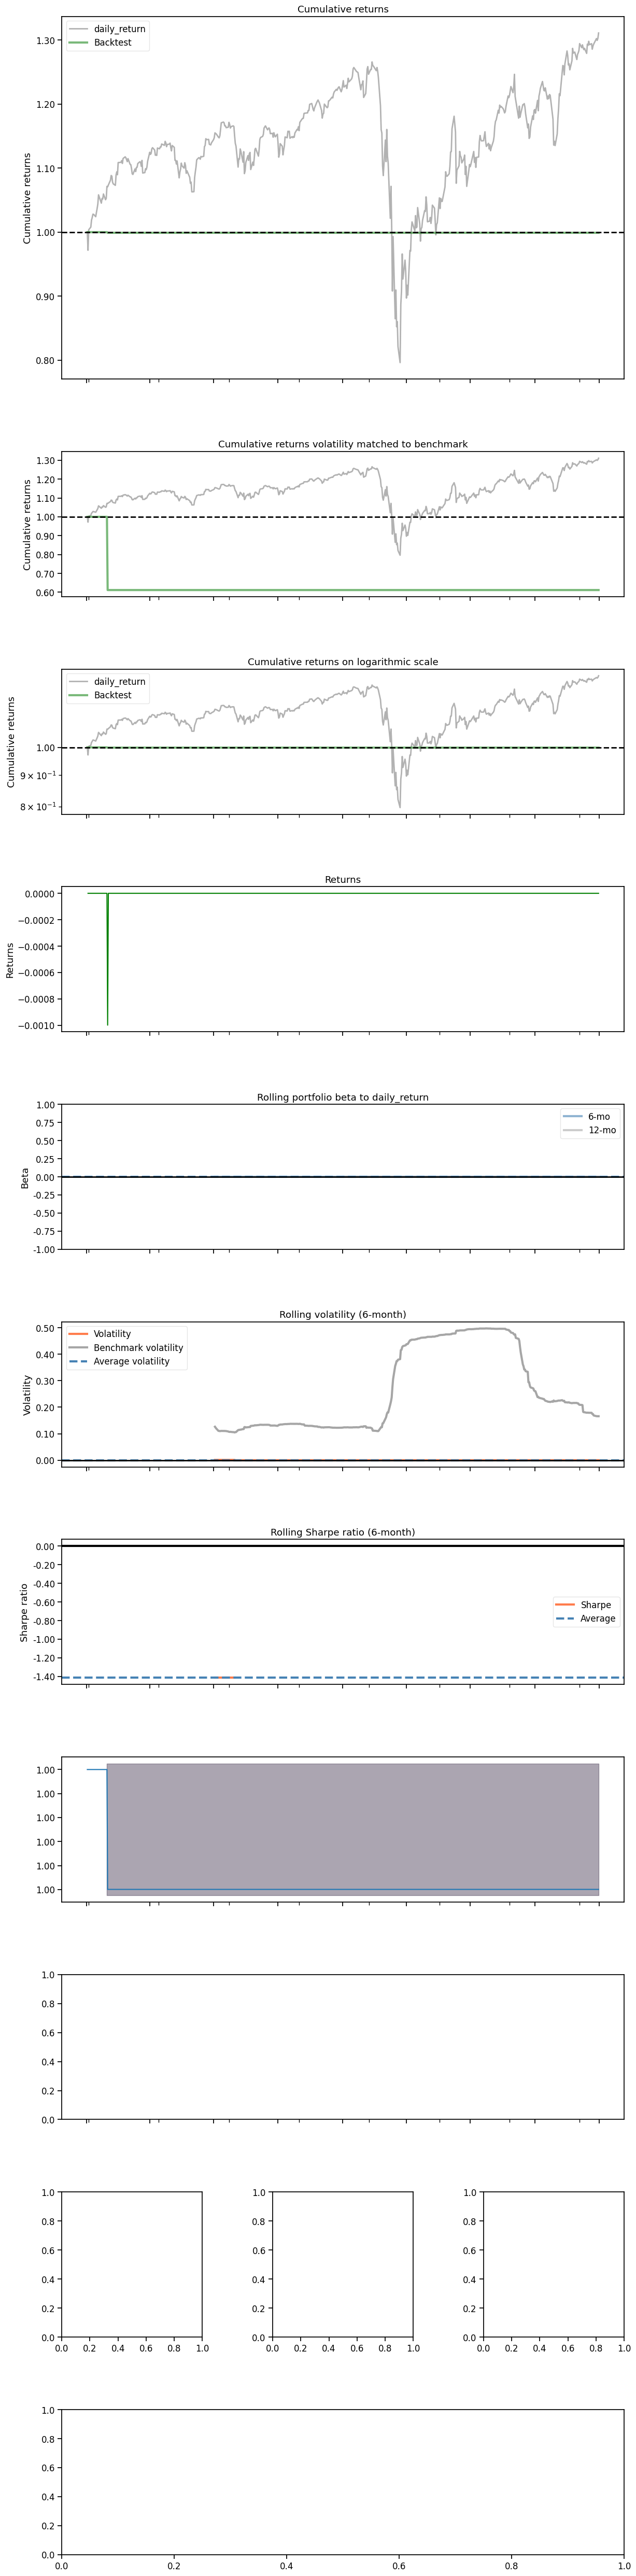

In [200]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(daily_account_value, 
            baseline_ticker = '^DJI', 
            baseline_start = TEST_START_DATE,
            baseline_end = TEST_END_DATE)

### Compare to Buy&Hold Strategy
pass in df_account_value, this information is stored in env class

<a id='6.2'></a>
## 7.2 BackTest with Buy&Hold Strategy

In [98]:
# print(DOW_30_TICKER)
test_portfolio = DOW_30_TICKER
len(test_portfolio)

30

In [99]:
modify_fields = ['open','high','low','close']
used_columns = ['date','close']

In [ ]:
# df_stock_test_ = get_baseline(
#         ticker='AXP', 
#         start = TEST_START_DATE,
#         end = TEST_END_DATE)
# df_stock_test_

In [ ]:
# for field in modify_fields:
#     df_stock_test_[field] = df_stock_test_[field]/df_stock_test_.iloc[0][field]/len(test_portfolio)
# df_stock_test_ = df_stock_test_[used_columns]

In [100]:
daily_account_value.shape

(505, 2)

In [101]:
#baseline stats
print("==============Get Baseline Stats===========")
shape = daily_account_value.shape
df_hold_ = pd.DataFrame(0,index=range(shape[0]), columns=range(shape[1]))
df_hold_.columns = used_columns
df_hold_['date'] = daily_account_value.date

for stock in test_portfolio:
    df_stock_ = get_baseline(
        ticker=stock, 
        start = TEST_START_DATE,
        end = TEST_END_DATE)
    # for field in modify_fields:
    if len(df_stock_) < len(df_hold_):
        final_row = df_stock_.iloc[-1]
        new_rows = pd.DataFrame([final_row] * (len(df_hold_) - len(df_stock_)))
        df_stock_ = pd.concat([df_stock_, new_rows], ignore_index=True)
        
        for i in range(0,len(df_stock_) < len(df_hold_)):
            df_stock_.iloc[en(df_stock_)] = df_stock_.iloc[len(df_stock_-1)]
    df_stock_['close'] = df_stock_['close']/df_stock_.iloc[0]['close']/len(test_portfolio)
    df_hold_['close'] = df_hold_.close + df_stock_.close

stats = backtest_stats(df_hold_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (452, 8)
Annual return          0.195048
Cumulative returns     0.429149
Annual volatility      0.250640
Sharpe ratio           0.838481
Calmar ratio           0.619132
Stability              0.476441
Max drawdown          -0.315034
Omega ratio            1.199937
Sortino ratio          1.172877
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.808196
Daily value at risk   -0.030744
dtype: float64


In [102]:
df_hold_

,date,close
0,2019-01-02,1.000000
1,2019-01-03,0.975741
2,2019-01-04,1.006680
3,2019-01-07,1.012222
4,2019-01-08,1.021593
...,...,...
500,2020-12-24,1.410505
501,2020-12-28,1.422545
502,2020-12-29,1.419110
503,2020-12-30,1.420817


The model' calculation encompass the entire timeframe, including non-working days. To address this, we need to determine the most appropriate method to fill up the weekend plots, for example backfilling.

In [ ]:
# df_hold_.date = pd.to_datetime(df_hold_['date'])
# df_hold_ = pd.merge(df_account_value_ppo['date'],df_hold_,how='left')
# df_hold_.bfill(inplace=True)
# df_hold_

In [103]:
df_hold = pd.DataFrame()
df_hold['date'] = daily_account_value['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
# print("df_hold: ", df_hold)
# df_dji.to_csv("df_dji.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
# df_hold.to_csv("df_dji+.csv")

# df_account_value.to_csv('df_account_value.csv')

df_hold:                      hold
date                    
2019-01-02  1.000000e+06
2019-01-03  9.757408e+05
2019-01-04  1.006680e+06
2019-01-07  1.012222e+06
2019-01-08  1.021593e+06
...                  ...
2020-12-24  1.410505e+06
2020-12-28  1.422545e+06
2020-12-29  1.419110e+06
2020-12-30  1.420817e+06
2020-12-31  1.429149e+06

[505 rows x 1 columns]


==============Compare to Buy&Hold===========
result:                     stock          hold
date                                  
2019-01-31  1.000000e+06  1.064635e+06
2019-01-31  9.998889e+05  1.064635e+06
2019-01-31  9.997902e+05  1.064635e+06
2019-01-31  9.997025e+05  1.064635e+06
2019-01-31  9.996245e+05  1.064635e+06
...                  ...           ...
2020-12-31  1.437142e+06  1.429149e+06
2020-12-31  1.438817e+06  1.429149e+06
2020-12-31  1.441160e+06  1.429149e+06
2020-12-31  1.440828e+06  1.429149e+06
2020-12-31  1.441170e+06  1.429149e+06

[510 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

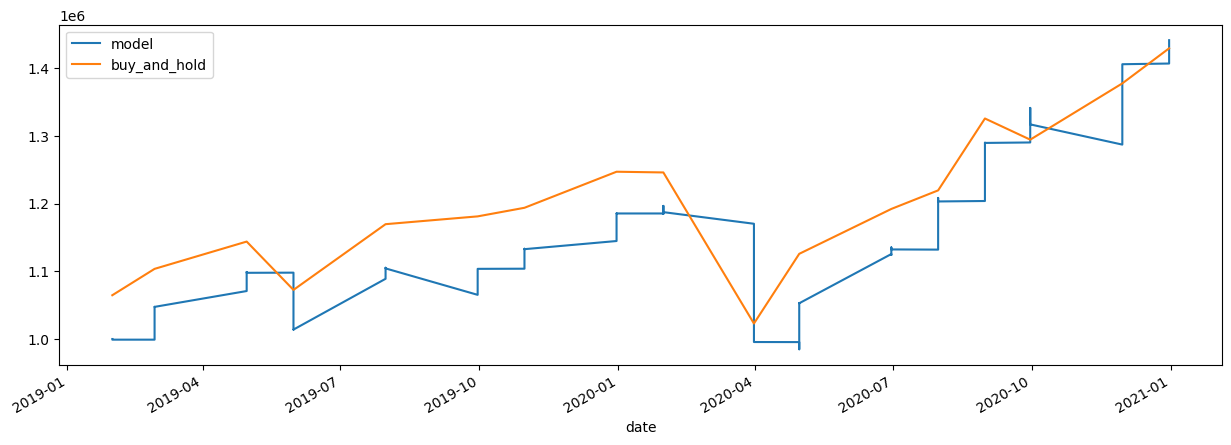

In [128]:
print("==============Compare to Buy&Hold===========")
df_result = pd.DataFrame({'date': df_account_value_sac['date'], 'stock': df_account_value_sac['account_value']})
df_result = df_result.set_index('date')

result = pd.DataFrame()
result = pd.merge(df_result, df_hold, left_index=True, right_index=True)
print("result: ", result)
# result.to_csv("result.csv")
result.columns = ['model', 'buy_and_hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

<a id='7'></a>
# 8. Save and load model #

<a id='7.1'></a>
## 8.1 Save model

### 8.1.1 Save trained model

In [43]:
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [44]:
model_name = "./"+TRAINED_MODEL_DIR+"/sac_model_600k_sac5"
model_name

'./trained_models/sac_model_600k_sac5'

In [131]:
trained_sac.save(model_name)

### 8.1.2 Save model as ONNX file

In [77]:
import torch as th
import torch.onnx
from stable_baselines3 import PPO
from stable_baselines3 import DDPG
from stable_baselines3.common.policies import BasePolicy
from typing import Tuple

In [78]:
class OnnxableSB3Policy(th.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: th.Tensor) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # NOTE: Preprocessing is included, but postprocessing
        # (clipping/inscaling actions) is not,
        # If needed, you also need to transpose the images so that they are channel first
        # use deterministic=False if you want to export the stochastic policy
        # policy() returns `actions, values, log_prob` for PPO
        return self.policy(observation, deterministic=True)

In [79]:
onnx_policy = OnnxableSB3Policy(trained_ppo.policy)
observation_size = trained_ppo.observation_space.shape
dummy_input = th.randn(1, *observation_size)

th.onnx.export(
    onnx_policy,
    dummy_input,
    "all_in_one_ppo.onnx",
    opset_version=17,
    input_names=["input"],
)

<a id='7.2'></a>
## 8.2 Load model

### 8.2.1 Load trained model

In [45]:
from stable_baselines3 import SAC
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [46]:
model_name = "./"+TRAINED_MODEL_DIR+"/sac_model_600k_sac5"
model_name

'./trained_models/sac_model_600k_sac5'

In [47]:
trained_model = SAC.load(model_name)

Continous training based on the previous model

In [48]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

In [49]:
agent_sac = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

In [50]:
trained_model.env = env_train

In [51]:
trained_sac = agent_sac.train_model(model=trained_model, 
                             tb_log_name='sac',
                             total_timesteps=100000)

Logging to tensorboard_log/test_sac/sac_7
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 79       |
|    time_elapsed    | 180      |
|    total_timesteps | 14400    |
| train/             |          |
|    actor_loss      | -6.45    |
|    critic_loss     | 0.00992  |
|    ent_coef        | 5.62e-11 |
|    ent_coef_loss   | 736      |
|    learning_rate   | 0.0003   |
|    n_updates       | 613699   |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 66       |
|    time_elapsed    | 434      |
|    total_timesteps | 28800    |
| train/             |          |
|    actor_loss      | -3.83    |
|    critic_loss     | 0.0181   |
|    ent_coef        | 4.21e-09 |
|    ent_coef_loss   | 602      |
|    learning_rate   | 0.0003   |
|    n_updates       | 628099   |
|    r

#### Test loaded model

In [106]:
test_env = StockTradingEnv(df = trade_data, **env_kwargs)

In [116]:
test_step = 1000
test_result = []
test_env.reset()
for i in range(0,test_step):
    observation = [test_env.state]
    observation = np.array(observation).astype(np.float32)
    actions, values, log_prob = ort_sess.run(None, {"input": observation})
    result = test_env.step(actions)
    test_result.append(result[1])
    if result[2] == True:
        break

### 8.2.2 Load ONNX model

In [44]:
import onnx
import onnxruntime as ort
import numpy as np

In [52]:
onnx_path = "all_in_one_ppo.onnx"
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

# # Check that the predictions are the same
# with th.no_grad():
#     print(model.policy(th.as_tensor(observation), deterministic=True))

In [74]:
observation = np.zeros((1, state_space)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
actions, values, log_prob = ort_sess.run(None, {"input": observation})
print(actions, values, log_prob)

[[-0.18915609]] [[11.657145]] [-0.9448749]
